In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [50]:
data = np.load('board_grade.npy', allow_pickle=True)

In [51]:
x, y = data[:, 1], data[:, 0]

In [52]:
for i in range(y.shape[0]):
    try:
        assert y[i].shape == y[i+1].shape
    except:
        if i + 1 < y.shape[0]:
            print(y[i+1])

In [53]:
all_boards = np.stack(x).reshape(-1, 18, 11, 2)
all_classes = np.stack(y).reshape(-1, 7)

In [54]:
train_boards, train_classes, valid_boards, valid_classes = train_test_split(all_boards, all_classes, test_size=0.2)

In [55]:
train_boards.shape

(24412, 18, 11, 2)

In [56]:
grade_to_list = {
    "V4 (6B+)": tuple([0,0,0,0,0,0,0]),
    "V5 (6C/+)": tuple([1,0,0,0,0,0,0]),
    "V6 (7A)": tuple([1,1,0,0,0,0,0]),
    "V7 (7A+)": tuple([1,1,1,0,0,0,0]),
    "V8 (7B/+)": tuple([1,1,1,1,0,0,0]),
    "V9 (7C)": tuple([1,1,1,1,1,0,0]),
    "V10 (7C+)": tuple([1,1,1,1,1,1,0]),
    "V11 (8A) or harder": tuple([1,1,1,1,1,1,1]),
}

grade_num_to_list = {
    0: tuple([0,0,0,0,0,0,0]),
    1: tuple([1,0,0,0,0,0,0]),
    2: tuple([1,1,0,0,0,0,0]),
    3: tuple([1,1,1,0,0,0,0]),
    4: tuple([1,1,1,1,0,0,0]),
    5: tuple([1,1,1,1,1,0,0]),
    6: tuple([1,1,1,1,1,1,0]),
    7: tuple([1,1,1,1,1,1,1]),
}

print_dict = {
    0: "M",
    1: "S",
    2: "E"
}

list_to_grade = dict((v,k) for k,v in grade_to_list.items())
list_to_grade_num = dict((v,k) for k,v in grade_num_to_list.items())

def print_board_bar():
    for i in range(26):
        print("-", end="")
    print()

def print_board(board, grade_list):
    print(" "*3, end="| ")
    for i in range(11):
        print(f"{chr(i + 65)}", end=" ")
    print()
    print_board_bar()
    for i in range(18):
        print(f"{18 - i:2} |", end=" ")
        for j in range(11):
            num_printed = False
            for c in range(2):
                if board[17 - i, j, c] > 0:
                    char = "M"
                    if c > 0:
                        char = "S" if i >= 12 else "E"
                    print(char, end=" ")  
                    num_printed = True
            if not num_printed:
                print("-", end=" ")
        print()
    print_board_bar()
        
    print(f"Problem Grade: {list_to_grade[tuple([round(x) for x in grade_list])]}")

def print_problem(problem_num):
    if problem_num < 0 or problem_num > all_boards.shape[0]:
        print("problem number out of bounds!")
        return -1
    print_board(all_boards[problem_num], all_classes[problem_num])

print_problem(1)
print()
print()
print_problem(5)
print()
print()
print_problem(10)

   | A B C D E F G H I J K 
--------------------------
18 | - - - - E - - - - - - 
17 | - - - - - - - - - - - 
16 | - - - - - - - - - - - 
15 | - - - - M - - - - - - 
14 | - - - - - - - - - - - 
13 | - - - - - - M - - - - 
12 | - - - - - - - - - - - 
11 | - - - - - - - - M - M 
10 | - - - - - - - - - - - 
 9 | - - - - - - - - - - - 
 8 | - - - - - - - - - M - 
 7 | - - - - - - - - - - - 
 6 | - - - - - - - - - - - 
 5 | - - - - - S - - - - - 
 4 | - - - - - - - - - - - 
 3 | - - - - - - - - - - - 
 2 | - - - - - - - - - - - 
 1 | - - - - - - - - - - - 
--------------------------
Problem Grade: V4 (6B+)


   | A B C D E F G H I J K 
--------------------------
18 | - - E - - - - - - - - 
17 | - - - - - - - - - - - 
16 | - - - M - - - - - - - 
15 | - - - - - - - - - - - 
14 | - - - - - - - - - - - 
13 | - - - M - - - - - - - 
12 | - - - - - - - - M - - 
11 | - - - - - - - - - - - 
10 | - - - - - - - - - - - 
 9 | - - - - - M - - - - - 
 8 | - - - - - - - - - - - 
 7 | - - - - - - - - - - 

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [58]:
# Convert data to PyTorch tensors
x_tensor = torch.tensor(all_boards, dtype=torch.float32)
y_tensor = torch.tensor(all_classes, dtype=torch.float32)
# create the dataset
dataset = data.TensorDataset(x_tensor, y_tensor)
val_size = int(len(dataset)*0.2)
train_size = len(dataset)- int(len(dataset)*0.2)
train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])

In [103]:
# create an oversampler
# Define a function to calculate class weights
def calculate_class_weights(dataset, num_classes):
    class_counts = [0] * num_classes

    # Count occurrences of each class in the dataset
    for sample in dataset:
        label = max([i+1 if x > 0 else 0 for i, x in enumerate(sample[1])])
        class_counts[label] +=  0.95 ** (label - 6) if label - 6 > 0 else 1

    # Calculate normalized class weights
    class_weights = [1 / (count) for count in class_counts]
    weights_total = sum(class_weights)
    class_weights_normalized = [weight / weights_total for weight in class_weights]

    return class_weights_normalized

# Calculate sample weights from class weights
class_weights = calculate_class_weights(train_dataset, 8)
labels = [max([i+1 if x > 0 else 0 for i, x in enumerate(sample[1])]) for sample in train_dataset]
sample_weights = [class_weights[label] for label in labels]

# Create upsampler using sample weights
train_sampler = data.WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)

print("Class weights:", class_weights)

Class weights: [0.00970098421644243, 0.010121338305712787, 0.021349923846812034, 0.03320572340634781, 0.029934354580572257, 0.12865074593406012, 0.2129518045233303, 0.5540851251867223]


In [104]:
INPUT_DIM = 18 * 11 * 2
OUTPUT_DIM = 7

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def calculate_accuracy(y_pred, y):
    thresh_pred = (y_pred > 0).float()
    thresh_y = (y > 0).float()
    correct = torch.tensor(0).to("cuda")
    for i in range(y.shape[0]):
        correct += thresh_y[i].equal(thresh_pred[i])
    acc = correct.float() / y.shape[0]
    return acc

def calculate_plus_minus_one(y_pred, y):
    y_pred = (y_pred > 0).float().to("cuda")
    y = (y > 0).float().to("cuda")
    correct = torch.tensor(0).to("cuda")
    for i in range(y.shape[0]):
        correct += (y_pred[i].eq(y[i]).sum() >= OUTPUT_DIM - 1)
    acc = correct.float() / y.shape[0]
    return acc

In [142]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 128)
        self.dropout = nn.Dropout(0.5)
        self.hidden_fc = nn.Linear(128, 32)
        self.output_fc = nn.Linear(32, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = self.dropout(F.mish(self.input_fc(x)))
        h_2 = self.dropout(F.mish(self.hidden_fc(h_1)))
        y_pred = self.output_fc(h_2)
        return y_pred, h_2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(INPUT_DIM, OUTPUT_DIM)

In [143]:
import time
from tqdm import tqdm

# fix the random seed; don't modify this
torch.manual_seed(23459078)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(INPUT_DIM, OUTPUT_DIM)
BATCH_SIZE = 8

train_iterator = data.DataLoader(train_dataset,
                                 #shuffle=True,
                                 sampler=train_sampler,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(val_dataset,
                                 batch_size=BATCH_SIZE)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

model = model.to(device)
criterion = criterion.to(device)

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    epoch_plus_minus = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        plus_minus = calculate_plus_minus_one(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_plus_minus += plus_minus.item()

    return epoch_loss / (len(iterator) * BATCH_SIZE), epoch_acc / len(iterator), epoch_plus_minus / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    epoch_plus_minus = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            plus_minus = calculate_plus_minus_one(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_plus_minus += plus_minus.item()

    return epoch_loss / (len(iterator) * BATCH_SIZE), epoch_acc / len(iterator), epoch_plus_minus / len(iterator)


EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc, train_plus_minus = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc, valid_plus_minus = evaluate(model, valid_iterator, criterion, device)

    if (0.2*train_loss + 0.8*valid_loss) < best_valid_loss: # save best model weights
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Train Acc +/- 1 Grade: {train_plus_minus*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.4f} |  Val. Acc: {valid_acc*100:.2f}% |  Val. Acc +/- 1 Grade: {valid_plus_minus*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.0426 | Train Acc: 32.26% | Train Acc +/- 1 Grade: 72.74%
	 Val. Loss: 0.0337 |  Val. Acc: 42.65% |  Val. Acc +/- 1 Grade: 80.35%


Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.0368 | Train Acc: 37.31% | Train Acc +/- 1 Grade: 78.72%
	 Val. Loss: 0.0287 |  Val. Acc: 47.29% |  Val. Acc +/- 1 Grade: 85.40%


Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 0.0354 | Train Acc: 37.85% | Train Acc +/- 1 Grade: 80.24%
	 Val. Loss: 0.0293 |  Val. Acc: 46.80% |  Val. Acc +/- 1 Grade: 84.35%


Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 0.0335 | Train Acc: 40.02% | Train Acc +/- 1 Grade: 81.97%
	 Val. Loss: 0.0270 |  Val. Acc: 48.63% |  Val. Acc +/- 1 Grade: 86.84%


Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 0.0320 | Train Acc: 41.87% | Train Acc +/- 1 Grade: 83.33%
	 Val. Loss: 0.0280 |  Val. Acc: 46.29% |  Val. Acc +/- 1 Grade: 86.45%


Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.0311 | Train Acc: 43.50% | Train Acc +/- 1 Grade: 84.36%
	 Val. Loss: 0.0271 |  Val. Acc: 47.19% |  Val. Acc +/- 1 Grade: 87.06%


Epoch: 07 | Epoch Time: 0m 8s
	Train Loss: 0.0300 | Train Acc: 44.40% | Train Acc +/- 1 Grade: 85.57%
	 Val. Loss: 0.0260 |  Val. Acc: 48.24% |  Val. Acc +/- 1 Grade: 88.05%


Epoch: 08 | Epoch Time: 0m 8s
	Train Loss: 0.0291 | Train Acc: 45.13% | Train Acc +/- 1 Grade: 86.22%
	 Val. Loss: 0.0256 |  Val. Acc: 49.62% |  Val. Acc +/- 1 Grade: 88.23%


Epoch: 09 | Epoch Time: 0m 8s
	Train Loss: 0.0282 | Train Acc: 46.55% | Train Acc +/- 1 Grade: 86.70%
	 Val. Loss: 0.0259 |  Val. Acc: 48.21% |  Val. Acc +/- 1 Grade: 88.64%


Epoch: 10 | Epoch Time: 0m 8s
	Train Loss: 0.0277 | Train Acc: 47.46% | Train Acc +/- 1 Grade: 87.49%
	 Val. Loss: 0.0260 |  Val. Acc: 48.03% |  Val. Acc +/- 1 Grade: 88.05%


Epoch: 11 | Epoch Time: 0m 8s
	Train Loss: 0.0272 | Train Acc: 47.91% | Train Acc +/- 1 Grade: 87.98%
	 Val. Loss: 0.0254 |  Val. Acc: 50.03% |  Val. Acc +/- 1 Grade: 88.91%


Epoch: 12 | Epoch Time: 0m 8s
	Train Loss: 0.0270 | Train Acc: 48.56% | Train Acc +/- 1 Grade: 87.91%
	 Val. Loss: 0.0254 |  Val. Acc: 49.98% |  Val. Acc +/- 1 Grade: 88.27%


Epoch: 13 | Epoch Time: 0m 7s
	Train Loss: 0.0263 | Train Acc: 48.67% | Train Acc +/- 1 Grade: 88.61%
	 Val. Loss: 0.0248 |  Val. Acc: 50.68% |  Val. Acc +/- 1 Grade: 89.20%


Epoch: 14 | Epoch Time: 0m 7s
	Train Loss: 0.0257 | Train Acc: 49.89% | Train Acc +/- 1 Grade: 88.97%
	 Val. Loss: 0.0242 |  Val. Acc: 52.04% |  Val. Acc +/- 1 Grade: 89.99%


Epoch: 15 | Epoch Time: 0m 7s
	Train Loss: 0.0257 | Train Acc: 49.59% | Train Acc +/- 1 Grade: 89.20%
	 Val. Loss: 0.0254 |  Val. Acc: 49.60% |  Val. Acc +/- 1 Grade: 88.48%


Epoch: 16 | Epoch Time: 0m 7s
	Train Loss: 0.0254 | Train Acc: 50.08% | Train Acc +/- 1 Grade: 89.39%
	 Val. Loss: 0.0237 |  Val. Acc: 51.89% |  Val. Acc +/- 1 Grade: 90.05%


Epoch: 17 | Epoch Time: 0m 7s
	Train Loss: 0.0252 | Train Acc: 50.82% | Train Acc +/- 1 Grade: 89.59%
	 Val. Loss: 0.0242 |  Val. Acc: 51.55% |  Val. Acc +/- 1 Grade: 90.33%


Epoch: 18 | Epoch Time: 0m 7s
	Train Loss: 0.0250 | Train Acc: 50.70% | Train Acc +/- 1 Grade: 89.72%
	 Val. Loss: 0.0246 |  Val. Acc: 49.21% |  Val. Acc +/- 1 Grade: 89.97%


Epoch: 19 | Epoch Time: 0m 7s
	Train Loss: 0.0247 | Train Acc: 50.70% | Train Acc +/- 1 Grade: 90.20%
	 Val. Loss: 0.0243 |  Val. Acc: 51.35% |  Val. Acc +/- 1 Grade: 89.99%


Epoch: 20 | Epoch Time: 0m 7s
	Train Loss: 0.0247 | Train Acc: 51.63% | Train Acc +/- 1 Grade: 90.12%
	 Val. Loss: 0.0243 |  Val. Acc: 51.26% |  Val. Acc +/- 1 Grade: 89.87%


In [147]:
import math
# grab a boulder from the validation set and see what the net thinks
view_iterator = data.DataLoader(val_dataset,
                                 shuffle=True,
                                 batch_size=1)

# get the best performing model weights
model.load_state_dict(torch.load('tut1-model.pt'))

# set it up properly for viewing + prediction
board, grade = next(iter(view_iterator))
print(board.shape)
view_board = board.reshape(18, 11, 2)
view_grade = grade.reshape(7)
board = board.to(device)
grade = grade.to(device)
print_board(view_board, view_grade.numpy())
pred = model.eval()(board)[0].cpu()
pred_numpy = pred.detach().numpy().reshape(7)
pred_sig_numpy = torch.sigmoid(pred).detach().numpy().reshape(7)
rounded_pred = np.round(pred_sig_numpy, 1)
thresholded_pred = tuple(1 if x > 0 else 0 for x in pred_numpy)
print(f"NN Estimation: {list_to_grade[thresholded_pred]}")
print(f"Full correct class: {view_grade.numpy()}")
print(f"Model estim. class: {rounded_pred}")


torch.Size([1, 18, 11, 2])
   | A B C D E F G H I J K 
--------------------------
18 | - - - E - - - - - - - 
17 | - - - - - - - - - - - 
16 | - - - - - - - - - - - 
15 | - - - - M - - - - - - 
14 | - - - - - - - - - - - 
13 | - - - M - - - - - - - 
12 | - - - - - - - - - - - 
11 | - - - - - - - - - - - 
10 | - M - - - - - - - - - 
 9 | - - - - - - - - - - - 
 8 | - - - M - - - - - - - 
 7 | - - - - - - - - - - - 
 6 | - - - S - - - - - - - 
 5 | - - - - - - - - - - - 
 4 | - S - - - - - - - - - 
 3 | - - - - - - - - - - - 
 2 | - - - - - - - - - - - 
 1 | - - - - - - - - - - - 
--------------------------
Problem Grade: V6 (7A)
NN Estimation: V6 (7A)
Full correct class: [1. 1. 0. 0. 0. 0. 0.]
Model estim. class: [0.9 0.5 0.3 0.1 0.  0.  0. ]


In [145]:
# create confusion matrix for model
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

def get_stats(model, iterator, device):

    epoch_loss = 0
    epoch_acc = 0
    epoch_plus_minus = 0

    model.eval()

    pred_classes = []
    true_classes = []
    roc_pred_classes = []
    roc_true_classes = []

    cf_pred = []
    cf_true = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Creating confusion matrix from model", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            # convert matrix into class
            for idx, item in enumerate(y_pred):
                true_y = y[idx]
                max_idx_pred = max([i+1 if x > 0 else 0 for i, x in enumerate(item)])
                max_idx_true = max([i+1 if x > 0 else 0 for i, x in enumerate(true_y)])
                pred_classes.append(tuple([1 if idx == max_idx_pred else 0 for i in range(len(item))]))
                true_classes.append(tuple([1 if idx == max_idx_true else 0 for i in range(len(item))]))
                roc_pred_classes.append(tuple([item[i].item() for i in range(len(item))]))
                roc_true_classes.append(tuple([true_y[i].item() for i in range(len(item))]))
                cf_pred.append(max_idx_pred)
                cf_true.append(max_idx_true)

    return confusion_matrix(cf_true, cf_pred), \
        roc_auc_score(roc_true_classes, roc_pred_classes, average='weighted', multi_class='ovr'), \
        f1_score(true_classes, pred_classes, average='weighted')

Training set metrics:
AUC Score: 0.9460 | F1 Score: 0.7967


[Text(0.5, 23.52222222222222, 'Predicted Labels'),
 Text(50.722222222222214, 0.5, 'True Labels')]

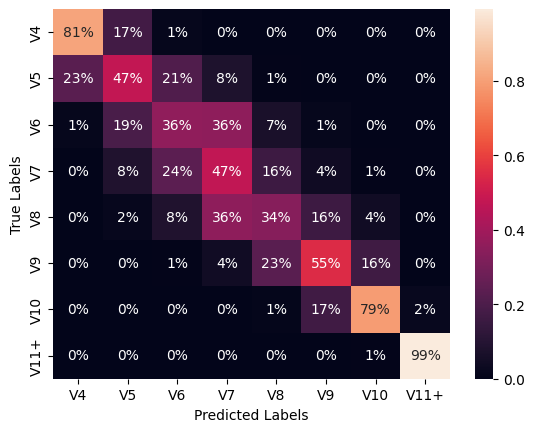

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt

ticklabels = ["V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11+"]

# get train set stats
train_cf_iter = data.DataLoader(train_dataset,
                                 shuffle=False,
                                 batch_size=1)

# get valid set stats
valid_cf_iter = data.DataLoader(val_dataset,
                                 shuffle=False,
                                 batch_size=1)

cf_matrix, auc, f1 = get_stats(model, train_cf_iter, device)
cf_matrix_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

print(f"Training set metrics:")
print(f"AUC Score: {auc:0.4f} | F1 Score: {f1:0.4f}")
ax = sns.heatmap(cf_matrix_norm, annot=True, fmt='.0%', xticklabels=ticklabels, yticklabels=ticklabels)
ax.set(xlabel="Predicted Labels", ylabel="True Labels")

Validation set metrics:
AUC Score: 0.9403 | F1 Score: 0.7947


[Text(0.5, 23.52222222222222, 'Predicted Labels'),
 Text(50.722222222222214, 0.5, 'True Labels')]

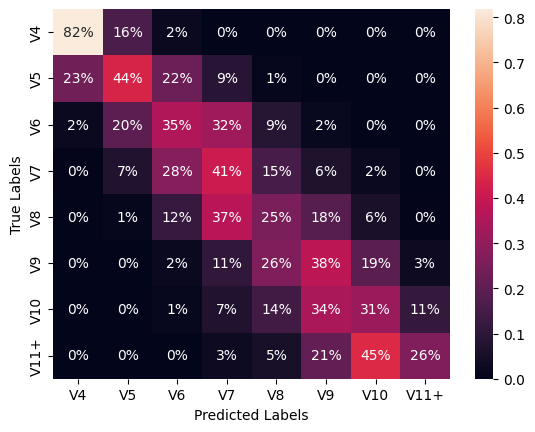

In [148]:
# get valid set stats
cf_matrix, auc, f1 = get_stats(model, valid_cf_iter, device)
cf_matrix_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

print(f"Validation set metrics:")
print(f"AUC Score: {auc:0.4f} | F1 Score: {f1:0.4f}")
ax = sns.heatmap(cf_matrix_norm, annot=True, fmt='.0%', xticklabels=ticklabels, yticklabels=ticklabels)
ax.set(xlabel="Predicted Labels", ylabel="True Labels")

In [293]:
# save the model for inference
torch.save(model, 'moonboard-clf.pth')

In [150]:
# save using onnx runtime for inference
model = model.to(device)
board = board.to(device)
torch.onnx.export(model,                     # model being run
                  board,                     # model input (or a tuple for multiple inputs)
                  "moonboard_clf.onnx",      # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                            # the ONNX version to export the model to
                    # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})